Figure 3: Timing of shock predicting cells

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
%matplotlib ipympl
Fig3a = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6, constrained_layout=False)  # size=(7.2, 5.3) if not scaling properly
print(Fig3.fig.get_size_inches())
Fig3astats = Fig(num="Figure 3 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=3) 
print(Fig3stats.fig.get_size_inches())
Fig3acomb = FigMirror(Fig3a, Fig3astats)

In [104]:
def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    if len(all_) == 1:
        return np.array(all_, dtype=int).squeeze()
    else:
        return np.around(np.mean(all_)).astype(int).squeeze()

In [122]:
def snake_plot(rasters, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    peak_id = np.array([allmax(rast) for rast in rasters])
    sort_ids = np.argsort(peak_id)
    sns.heatmap(rasters[sort_ids])
    
    return ax, peak_id
    

In [123]:
def freeze_group_snake_plot(group, arena, day, buffer_sec=(2, 2)):
    """Plot freeze-tuned cells for each group/day"""
    freeze_rasts = []
    srs = []
    for mouse in group:
        MD1 = fa.MotionTuning(mouse, arena, day)
        MD1.gen_pe_rasters(buffer_sec=buffer_sec)
        freeze_cells = MD1.select_cells('freeze_fine')
        rast_use = MD1.pe_rasters['freeze_onset'][freeze_cells]
        freeze_rasts.append(rast_use)
        srs.append(MD1.sr_image)

    freeze_rasts_mean_comb = np.concatenate([rast_ind.mean(axis=1) for rast_ind in freeze_rasts], axis=0)

    assert np.mean(srs) == srs[0], 'Fix code to work with different sample rates'
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/srs[0])

#     peak_id = [np.argmax(rast_mean) for rast_mean in freeze_rasts_mean_comb]
#     peak_id = np.array([allmax(rast_mean) for rast_mean in freeze_rasts_mean_comb])
#     sort_ids = np.argsort(peak_id)
#     _, ax = plt.subplots()
#     sns.heatmap(freeze_rasts_mean_comb[sort_ids])
    ax, peak_id = snake_plot(freeze_rasts_mean_comb)
    ax.set_xticks([0, int(len(times)/2), len(times)])
    ax.set_xticklabels([-buffer_sec[0], 0, buffer_sec[1]])
    
    return ax, peak_id, times

In [41]:
# Pre-allocate dictionary
rast_dict = {'Learners': {}, 'Non-Learners': {}, 'ANI': {}}

In [48]:
rast_dict['Learners'][-1].mean()

-0.6318181818181805

In [50]:
[times.mean() for times in rast_dict['Learners'].values()]

[-0.6851063829787223,
 -0.6318181818181805,
 -0.6036585365853646,
 -0.4089743589743576,
 -0.8236842105263147]

In [58]:
rast_dict['Learners'][2]

array([ 7.00000000e-01, -1.35000000e+00, -5.00000000e-01, -1.90000000e+00,
       -1.00000000e+00,  3.50000000e-01, -1.25000000e+00, -1.95000000e+00,
       -6.50000000e-01, -1.80000000e+00,  7.00000000e-01,  7.50000000e-01,
       -1.50000000e+00, -1.60000000e+00, -1.20000000e+00, -1.20000000e+00,
       -6.00000000e-01, -1.00000000e+00, -9.50000000e-01, -1.35000000e+00,
       -9.50000000e-01, -4.50000000e-01, -5.00000000e-01,  1.77635684e-15,
        1.00000000e-01, -4.00000000e-01, -3.50000000e-01, -1.70000000e+00,
       -3.00000000e-01, -6.50000000e-01, -1.50000000e+00, -1.15000000e+00,
       -1.10000000e+00, -8.00000000e-01, -8.50000000e-01, -1.35000000e+00,
       -7.50000000e-01, -1.30000000e+00])

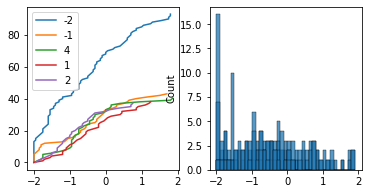

In [67]:
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for day in [-2, -1, 4, 1, 2]:
    ax[0].plot(np.sort(rast_dict['Learners'][day]), np.arange(len(rast_dict['Learners'][day])))
#     sns.ecdfplot(rast_dict['Learners'][day], ax=ax[1])
    sns.histplot(rast_dict['Learners'][day], bins=np.arange(-2, 2, 0.1))
ax[0].legend([-2, -1, 4, 1, 2])


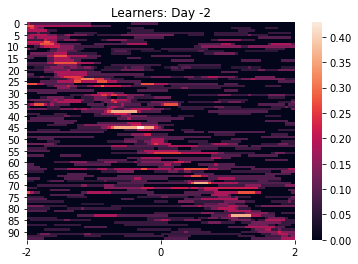

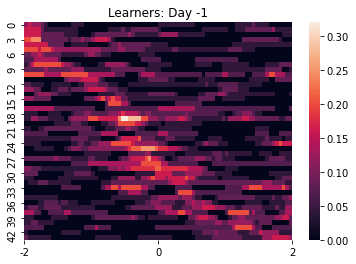

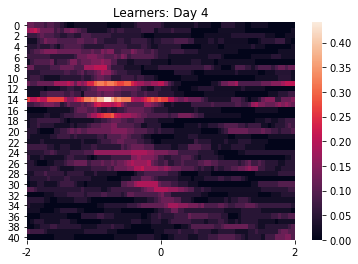

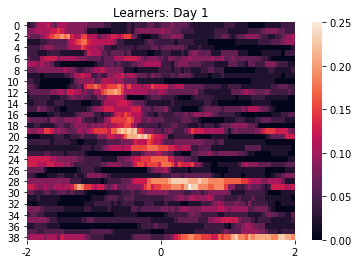

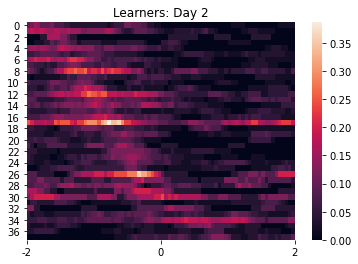

In [124]:
group, lgroup = 'Learners', err.learners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, lrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[lrn_ids]
    
    ax.set_title(f'{group}: Day {day}')

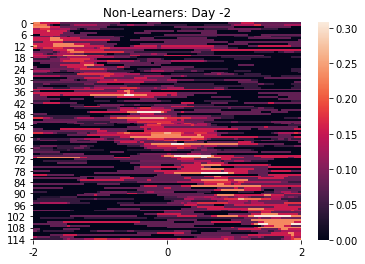

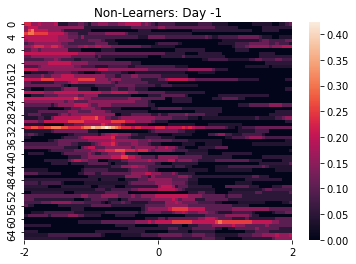

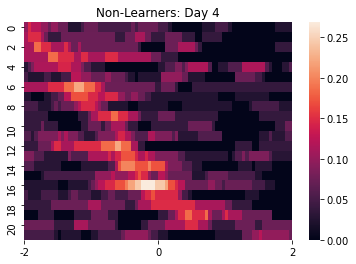

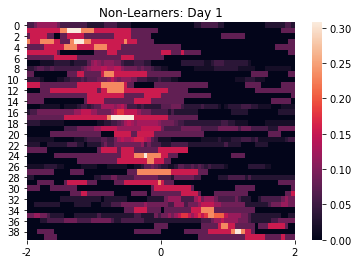

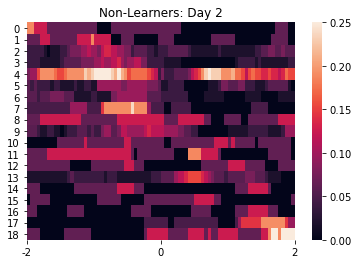

In [110]:
group, lgroup = 'Non-Learners', err.nonlearners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, nlrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[nlrn_ids]
    ax.set_title(f'{group}: Day {day}')

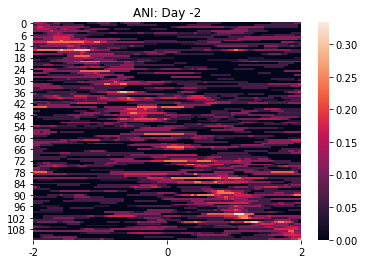

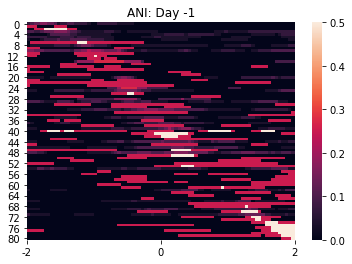

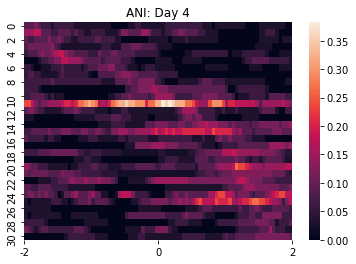

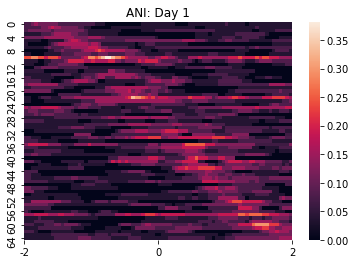

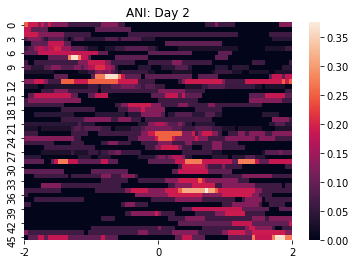

In [111]:
# Need to fix and add in Marble20 which has a 20Hz sample rate
group, lgroup = 'ANI', ['Marble17', 'Marble18', 'Marble19', 'Marble25']
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    ax, ani_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[ani_ids]
    ax.set_title(f'{group}: Day {day}')

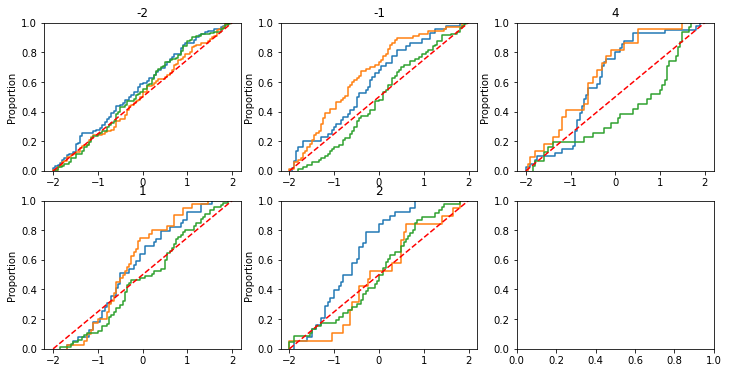

In [113]:
_, ax = plt.subplots(2, 3, figsize=(12, 6))

for a, day in zip(ax.reshape(-1), [-2, -1, 4, 1, 2]):
    for group in ['Learners', 'Non-Learners', 'ANI']:
        sns.ecdfplot(rast_dict[group][day], ax=a)
    a.plot([-2, 2], [0, 1], 'r--')
    a.set_title(str(day))

[-0.2971014492753608, -0.24697802197802043, -0.04410256410256236]
[-0.4841463414634133, -0.668181818181817, 0.3548387096774215]
[-0.4499999999999986, -0.19999999999999835, 0.03693693693693875]


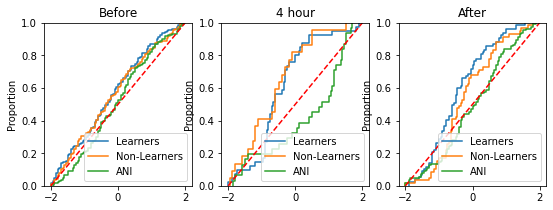

In [116]:
# Group by Before-4-After
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, day_group, sesh_time in zip(ax.reshape(-1), [[-2, -1], [4], [1, 2]], ['Before', '4 hour', 'After']):
    means_print = []
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a)
        means_print.append(np.mean(np.concatenate(rast_use)))
    print(means_print)
    a.plot([-2, 2], [0, 1], 'r--')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)

<AxesSubplot:ylabel='Proportion'>

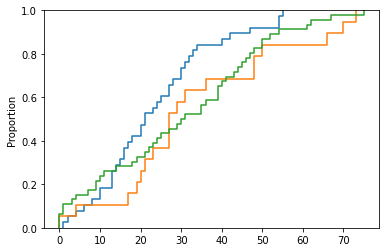

In [39]:
_, ax = plt.subplots()
sns.ecdfplot(lrn_ids, ax=ax)
sns.ecdfplot(nlrn_ids, ax=ax)
sns.ecdfplot(ani_ids, ax=ax)

In [ ]:
# plot mean transient event rate rasters centered on freezing

In [169]:
MD14 = fa.MotionTuning('Marble14', 'Shock', 1)

No tunings found for Marble14 Shock day 1: run .get_tuning_sig() and .save_sig_tuning()


In [173]:
PBErast14 = fa.get_PE_raster(MD14.PSAbool.sum(axis=0), MD14.select_events('freeze_onset'), 
                           sr_image=MD14.sr_image, buffer_sec=(6,6))
PBErast14.shape

(8, 120)

In [179]:
np.sum((6, 6))*20

240

In [177]:
times14 = np.linspace(-6, 6, PBErast14.shape[1]+1)
print(times14)
print(np.linspace(-6, 6, 241))

[-6.  -5.9 -5.8 -5.7 -5.6 -5.5 -5.4 -5.3 -5.2 -5.1 -5.  -4.9 -4.8 -4.7
 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7 -3.6 -3.5 -3.4 -3.3
 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9
 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5
 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1
  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6. ]
[-6.   -5.95 -5.9  -5.85 -5.8  -5.75 -5.7  -5.65 -5.6  -5.55 -5.5  -5.45
 -5.4  -5.35 -5.3  -5.25 -5.2  -5.15 -5.1  -5.05 -5.   -4.95 -4.9  -4.85
 -4.8  -4.75 -4.7  -4.65 -4.6  -4.55 -4.5  -4.45 -4.4  -4.35 -4.3  -4.25
 -4.2  -4.15 -4.1  -4.05 -4.   -3.95 -3.9  -3.85 -3.8  -3.75 -3.7  -3.65
 -3.6  -3.55 -3.5  -3.45 -3.4  -3.35 -3.3  -3.25 -3.2  -3.15 -3.1  -3.05
 -3.   -2.95 -2.9  -

In [162]:
def get_group_PBE_rasters(animal_list, buffer_sec_use=(6, 6), event_type='freeze_onset'):
    """Gets rasters of population level calcium activity centered on specified events default = freeze onset"""
    
    nanimals = len(animal_list)
    PBEdict = {}
    for day in  [-2, -1, 4, 1, 2]:
        PBErast_comb, times_comb = [], []
        for animal in animal_list:
            MD1 = fa.MotionTuning(animal, 'Shock', day)
            PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
                                       sr_image=MD1.sr_image, buffer_sec=buffer_sec_use)
#             PBErast_comb.append(PBErast.mean(axis=0)/MD1.PSAbool.shape[0])
#             times_comb.append(np.linspace(-buffer_sec_use[0], buffer_sec_use[1], PBErast.shape[1]))
            PBErast_comb.extend(PBErast.mean(axis=0)/MD1.PSAbool.shape[0])
#             times_comb.extend(np.linspace(-buffer_sec_use[0], buffer_sec_use[1], PBErast.shape[1]))
            times_comb.extend(np.arange(-buffer_sec_use[0], buffer_sec_use[1], MD1.sr_image))  # bugfix
            
        # Assemble into dataframes for easy plotting later on
        PBEdict[day] = pd.DataFrame({'times': np.array(times_comb).reshape(-1), 
                                     'act_neuron_ratio': np.array(PBErast_comb).reshape(-1)})
        
    return PBEdict

In [163]:
from copy import copy
PBElearn = get_group_PBE_rasters(err.learners[0:4])
PBEnlearn = get_group_PBE_rasters(err.nonlearners)
PBEani = get_group_PBE_rasters(err.ani_mice_good)
# PBEani = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])
control_mice_good = copy(err.learners[0:4])
control_mice_good.extend(err.nonlearners)
PBEctrl = get_group_PBE_rasters(control_mice_good)

In [164]:
def plot_group_PBE_rasters(PBEdict, group_name, days=[-2, -1, 4, 1, 2], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 5, figsize=(16, 4))
    for day, a in zip(days, ax.reshape(-1)):
        df_test = PBEdict[day]
        sns.lineplot(data=df_test, x='times', y='act_neuron_ratio', ax=a)
        a.set_xlabel('Time from freeze (s)')
        a.set_ylabel('Prop. neurons active')
        a.set_title(f'{group_name} Day {day}')
    

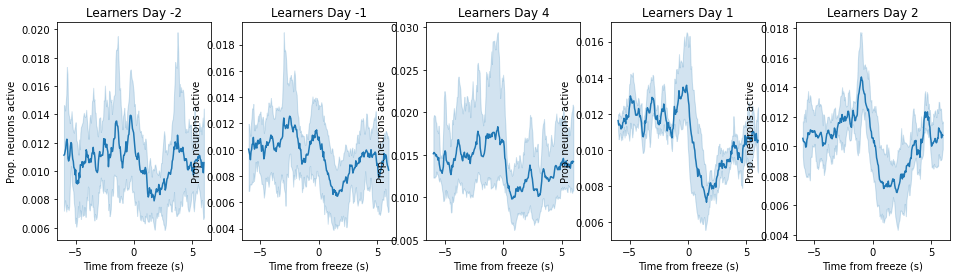

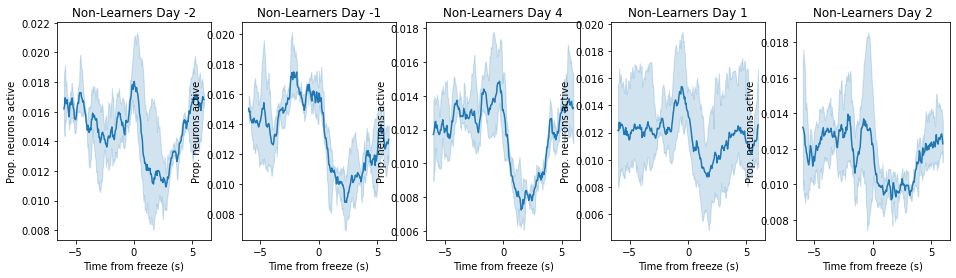

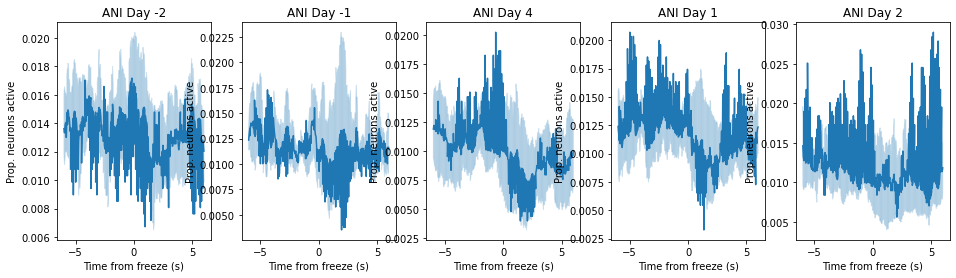

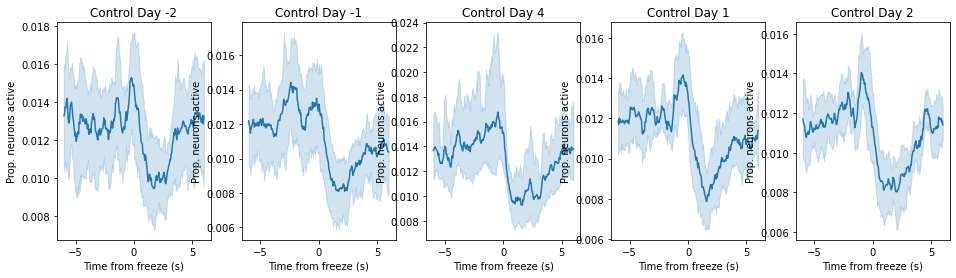

In [165]:
plot_group_PBE_rasters(PBElearn, 'Learners')
plot_group_PBE_rasters(PBEnlearn, 'Non-Learners')
plot_group_PBE_rasters(PBEani, 'ANI')
plot_group_PBE_rasters(PBEctrl, 'Control')

In [168]:
MD1.sr_image

array(20, dtype=uint8)

<IPython.core.display.Javascript object>


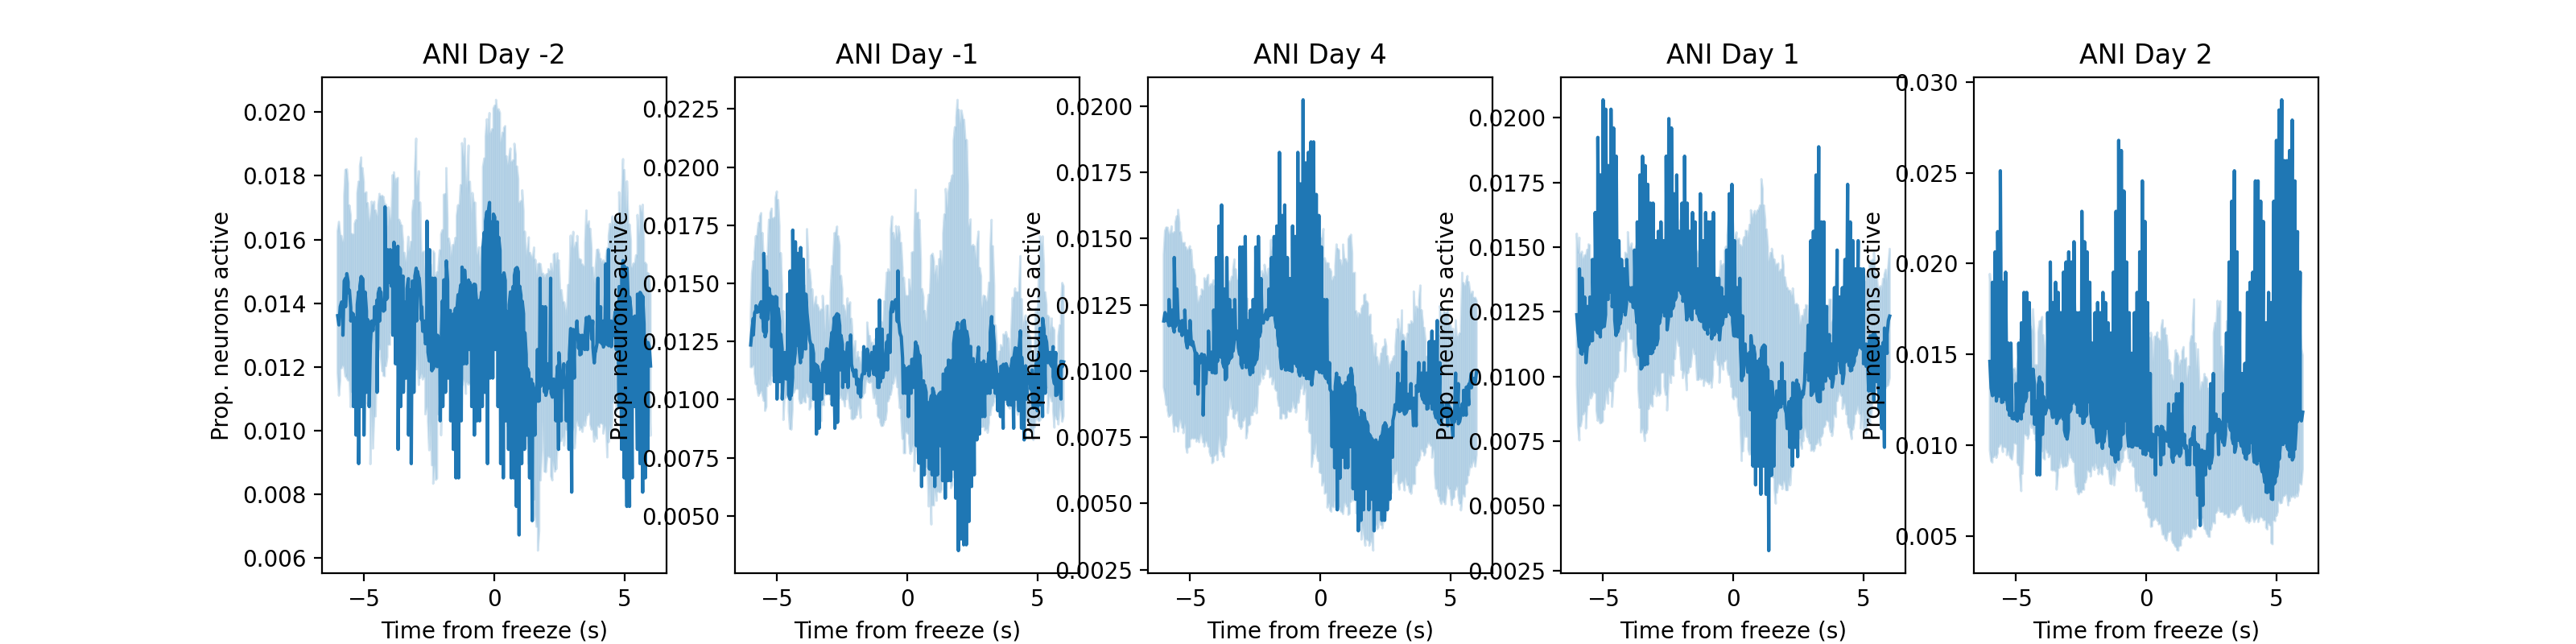

In [166]:
%matplotlib notebook
plot_group_PBE_rasters(PBEani, 'ANI')
# PBEani = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])

In [ ]:
# plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
# Fig3a.savefig(plot_path / 'Figure3a.pdf', scriptname='Figure3a.ipynb')
# Fig3astats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3a.ipynb')